In [ ]:
import pandas as pd
import os
import sys
import json
import matplotlib.pyplot as plt
from scipy.stats import gmean
import numpy as np
import matplotlib.ticker as mticker

import common

In [ ]:
from pathlib import Path

order = {}
def gen_plots(lib_name, sf, baseline_dir, cmp_dir, color, hatch, ylims=None, height_ratios=None,
              include_baseline=True, fig_text_x=0, fontsize=14, xticklabelsize=None, yticklabelsize=None, non_broken_ylim=None):
  assert (ylims is None) == (height_ratios is None)
  if yticklabelsize is None:
    yticklabelsize = fontsize - 2

  if lib_name == 'modin' or lib_name == 'dias':
    yticklabelsize = 20
    fontsize = 20
    yfontsize = 24
  else:
    yticklabelsize = 36
    xticklabelsize = 36
    fontsize = 40
    yfontsize = 32

  if lib_name == 'modin':
    xticklabelsize = 10
  elif lib_name == 'dias':
    xticklabelsize = 5

  directory = Path(baseline_dir)
  files = [f.name for f in directory.iterdir() if f.is_file()]
  files.remove('.version')
  files = sorted(files)
  id_mapping = {f: str(i + 1) for i, f in enumerate(files)}
  
  directory = Path(cmp_dir)
  cmp_files = {f.name for f in directory.iterdir() if f.is_file()}
  fnames = [f for f in files if f in cmp_files]
  num_nbs = len(fnames)
    
  def get_dir_times(dir_):
    nb_times = []
    nb_to_cells = {}
    for fname in fnames:
      with open(os.path.join(dir_, fname), 'r') as fp:
        cells = json.load(fp)['cells']

      cell_times = [cell['total-ns'] for cell in cells]
      cell_times_ms = [common.ns_to_ms(t) for t in cell_times]
      cell_times_ms = pd.Series(cell_times_ms)
      nb_time = cell_times_ms.sum()
      nb_times.append(nb_time)
      nb_to_cells[fname] = cell_times_ms
    ### END FOR ###

    nb_times = pd.Series(nb_times, index=fnames)
    return nb_times, nb_to_cells
    
  t_base, t_base_cells = get_dir_times(baseline_dir)
  t_cmp, t_cmp_cells = get_dir_times(cmp_dir)
  rel_speed = t_base / t_cmp
  print(sum([1 if entry > 1 else 0 for entry in rel_speed]))
  if True: # lib_name not in order:
    _, nbs = zip(*sorted(list(zip(rel_speed, rel_speed.index))))
    order[lib_name] = nbs
  nbs = order[lib_name]
  nbs = [nb for nb in nbs if nb in rel_speed.index]
  rel_speed = pd.Series([rel_speed[nb] for nb in nbs], index=nbs)

  def plot_on_ax(ax):
    ax.bar([id_mapping[nb] for nb in rel_speed.index], rel_speed, color=color, hatch=hatch)
    # if include_baseline:
    ax.axhline(1, color='grey', linestyle='--', linewidth=1.5)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
#     ax.set_xticks([]) # comment out for xticks
    if lib_name == 'dask' or lib_name == 'koalas':
      plt.yticks(ticks=[0.0, 0.3, 0.6, 0.8, 1.0], fontsize=yticklabelsize)
    else:
      plt.yticks(fontsize=yticklabelsize)
    if xticklabelsize is not None:
      plt.xticks(fontsize=xticklabelsize)

    plt.margins(x=0.01)
    if lib_name == 'modin':
      ax.xaxis.set_label_coords(-0.12, -0.12)
      ax.set_xticklabels([])
      tick_lines = ax.xaxis.get_ticklines()  # Get all tick lines
      for i, nb in enumerate(rel_speed.index):
        # labels = [id_mapping[nb] for nb in rel_speed.index]
        label = id_mapping[nb]
        off = 0.1
        tick_off = 0
        if i % 2 == 0:
          off = 0.02
          tick_off = 0.2

        if int(label) >= 100 and off == 0.1:
          ax.text(i, -0.16 + off, label, ha='center', va='top', fontsize=8, transform=ax.transData)
        else:
          ax.text(i, -0.16 + off, label, ha='center', va='top', transform=ax.transData)

        tick_length = 5 + abs(tick_off) * 50  # Base length of 5, increases with y offset
    
        # Modify the corresponding major tick lines (each tick has two lines: top & bottom)
        tick_lines[2*i].set_markersize(tick_length)   # Bottom tick
      ### END FOR ###
    elif lib_name == 'dias':
      ax.xaxis.set_label_coords(-0.12, -0.12)
      ax.set_xticklabels([])
      tick_lines = ax.xaxis.get_ticklines()  # Get all tick lines
      for i, nb in enumerate(rel_speed.index):
        # labels = [id_mapping[nb] for nb in rel_speed.index]
        label = id_mapping[nb]
        off = 0.12
        tick_off = 0
        if i % 2 == 0:
          off = 0.06
          tick_off = 0.2

        if int(label) >= 100:
            ax.text(i, -0.16 + off, label, ha='center', va='top', fontsize=7, transform=ax.transData)
        else:
          ax.text(i, -0.16 + off, label, ha='center', va='top', fontsize=9, transform=ax.transData)

        tick_length = 5 + abs(tick_off) * 50  # Base length of 5, increases with y offset
    
        # Modify the corresponding major tick lines (each tick has two lines: top & bottom)
        tick_lines[2*i].set_markersize(tick_length)   # Bottom tick
      ### END FOR ###


#   ax = rel_speed.plot(kind='bar', figsize=(12, 5))
#   ax.axhline(1, color='grey', linestyle='--', linewidth=1.5)
#   ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
#   ax.set_xticks([])
##########################################
  fig, ax = None, None
  if ylims is not None:
    fig, (ax2, ax) = plt.subplots(2, 1, sharex=True, figsize=(12, 5), gridspec_kw={'height_ratios': height_ratios})
    fig.subplots_adjust(hspace=0.05)
  else:
    fig, ax = plt.subplots(figsize=(12, 5))

  #plot bars
  plot_on_ax(ax)
  if ylims is not None:
    plot_on_ax(ax2)

  #axis labels and title
  ax.set_xlabel(f"{num_nbs} Notebooks", fontsize=fontsize+2)
  if ylims is not None:
    fig.text(fig_text_x, 0.575, 'Relative Speedup', va='center', rotation='vertical', fontsize=fontsize)
    # legend at the top
#     ax2.legend(loc='upper center', bbox_to_anchor=(0.5, bbox_to_anchor_y), ncol=6, fontsize=13, frameon=False)
    
    ax2.set_ylim(ylims[1][0], ylims[1][1])
    ax.set_ylim(ylims[0][0], ylims[0][1])

    ax2.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)
    ax2.tick_params(labeltop=False)
#     ax2.set_xticks([]) # comment out for xticks
#     ax.xaxis.tick_bottom() # comment out for xticks
    
    kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=16,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
    ax.plot([0, 1], [1, 1], transform=ax.transAxes, **kwargs)
  else:
    if non_broken_ylim is not None:
      ax.set_ylim(non_broken_ylim)
    ax.set_ylabel("Relative Speedup", fontsize=yfontsize)

#############################################

  # SVG also seems to work actually.
  plt.savefig(f'./rel_speedups/{lib_name}_{sf}_nb_level_rel.png', format='png', dpi=200, bbox_inches='tight')
  plt.show()


  print((rel_speed > 1).sum())
    
  for nb in rel_speed.nlargest(10).index:
    print(nb)
    nb_abs = t_base_cells[nb] - t_cmp_cells[nb]
    if 'poiss0nriot_classifying-client-type-using-client-names' in nb and lib_name == 'modin' and sf == '20_sec':
      # drop empty
      nb_abs.drop([2, 4, 5, 7, 9, 10, 13, 14, 15], inplace=True)
      nb_abs /= 1_000
      fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(5, 3), gridspec_kw={'height_ratios': [1, 2.5]})

      # Plot bars on both axes
      # nb_abs.plot(ax=ax1, kind='bar', color='#D27D2D', hatch='O')
      # nb_abs.plot(ax=ax2, kind='bar', color='#D27D2D', hatch='O')
      neg_col = '#DBA979'
      pos_col = '#96B6C5'
      colors = 3*[neg_col] + 2*[pos_col] + 2*[neg_col]
      nb_abs.plot(ax=ax1, kind='bar', color=colors)
      nb_abs.plot(ax=ax2, kind='bar', color=colors)

      # Set axis limits
      ax1.set_ylim(17.98, 19)  # Focus on the high value
      ax2.set_ylim(-8, 0.5)   # Focus on the smaller values

      # Hide the spines between the axes
      ax1.spines['bottom'].set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax1.set_xticks([])

      ax2.tick_params(axis='x', rotation=0)  # Rotate without modifying labels

      ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
      ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')


      d = .5  # proportion of vertical to horizontal extent of the slanted line
      kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                    linestyle="none", color='k', mec='k', mew=1, clip_on=False)
      ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
      ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


      ax2.set_xlabel('Cell Index', fontsize=11)
      ax2.set_ylabel('Absolute Speedup (s)', fontsize=11)
      ax2.yaxis.set_label_coords(-0.12, 0.72)
      plt.savefig('./modin-notebook-speedup.png', format='png', dpi=400, bbox_inches='tight')
    else:
      pass
      # ax = nb_abs.plot(kind='bar', color='red', hatch='O')
    plt.show()
    
  abs_speed = t_base - t_cmp

  # ax = abs_speed.plot(kind='bar', figsize=(12, 5))
  # ax.axhline(1, color='red')
  # ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, color='lightgrey')
  # ax.set_xticks([])
  # ax.set_xlabel(f"{num_nbs} Notebooks", fontsize=16)
  # ax.set_ylabel("Absolute Speedup (ms)", fontsize=14)
  # plt.savefig(f'./rel_speedups/{lib_name}_{sf}_nb_level_abs.png', format='png', dpi=200, bbox_inches='tight')

## Modin

0


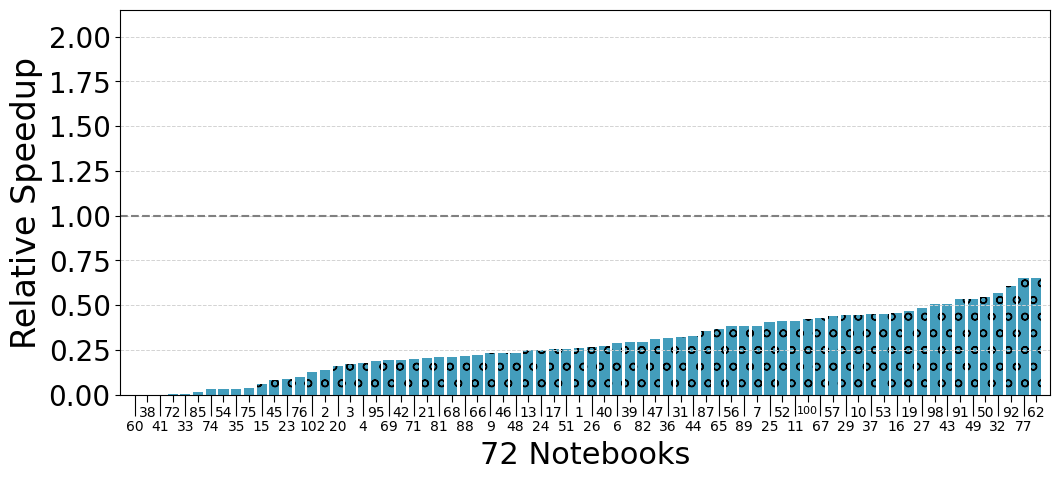

0
poiss0nriot_classifying-client-type-using-client-names.json
shashi772_data-cleaning-challenge-parsing-dates.json
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
jackwatson99_pima-indians-diabetes-rf-81.json
mathewvondersaar_analysis-of-student-performance.json
mahtieu_nyc-taxi-fare-prediction-data-expl-xgboost.json
ukveteran_sarima-time-series-eda-predict-jma-sao-paulo.json
kwullum_when-do-traffic-related-deaths-occur.json
xingobar_computer-science-data-visualization.json
gravix_gradient-in-a-box.json


In [ ]:
gen_plots('modin', '5_sec', './output-stats/stats-pandas-5-sec', './output-stats/stats-modin-5-sec',
          '#439DBC', 'o', include_baseline=False, fontsize=24, xticklabelsize=6, non_broken_ylim=(0, 2.15)) # ((0, 0.75), (1, 1.05)), [1, 15])

0


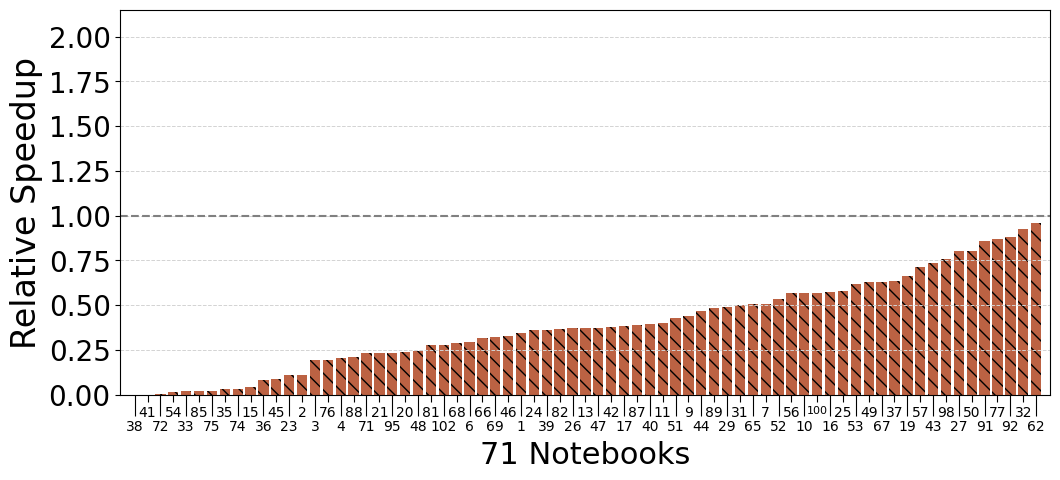

0
poiss0nriot_classifying-client-type-using-client-names.json
jackwatson99_pima-indians-diabetes-rf-81.json
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
shashi772_data-cleaning-challenge-parsing-dates.json
ukveteran_sarima-time-series-eda-predict-jma-sao-paulo.json
mathewvondersaar_analysis-of-student-performance.json
gravix_gradient-in-a-box.json
xingobar_computer-science-data-visualization.json
kwullum_when-do-traffic-related-deaths-occur.json
narasimhach_ashrae-data-preprocessing.json


In [ ]:
gen_plots('modin', '10_sec', './output-stats/stats-pandas-10-sec', './output-stats/stats-modin-10-sec',
          '#BC6243', '\\\\', fontsize=30, xticklabelsize=6, non_broken_ylim=(0, 2.15))

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Sample data
# data = pd.Series([-4800, -100, 50, 200, 20000])



8


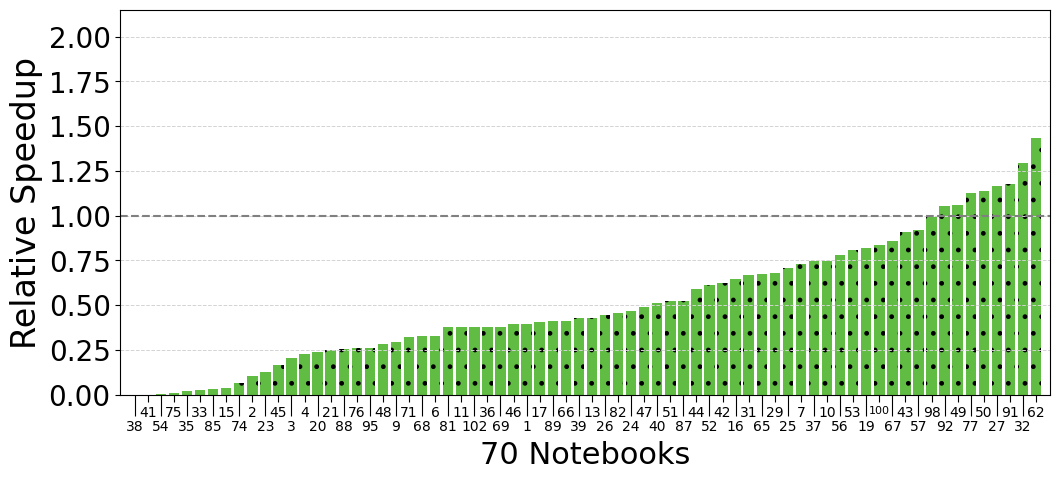

8
poiss0nriot_classifying-client-type-using-client-names.json


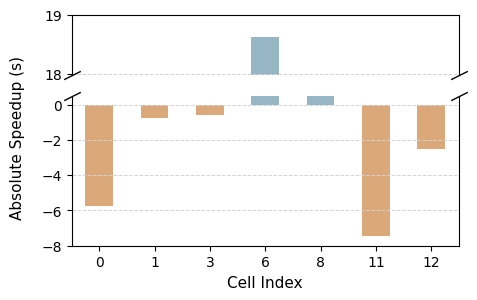

jackwatson99_pima-indians-diabetes-rf-81.json
ukveteran_sarima-time-series-eda-predict-jma-sao-paulo.json
gravix_gradient-in-a-box.json
mathewvondersaar_analysis-of-student-performance.json
shashi772_data-cleaning-challenge-parsing-dates.json
mahtieu_nyc-taxi-fare-prediction-data-expl-xgboost.json
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
xingobar_computer-science-data-visualization.json
narasimhach_ashrae-data-preprocessing.json


In [ ]:
gen_plots('modin', '20_sec', './output-stats/stats-pandas-20-sec', './output-stats/stats-modin-20-sec',
          '#61BC43', '.', fontsize=24, xticklabelsize=6, non_broken_ylim=(0, 2.15))

2


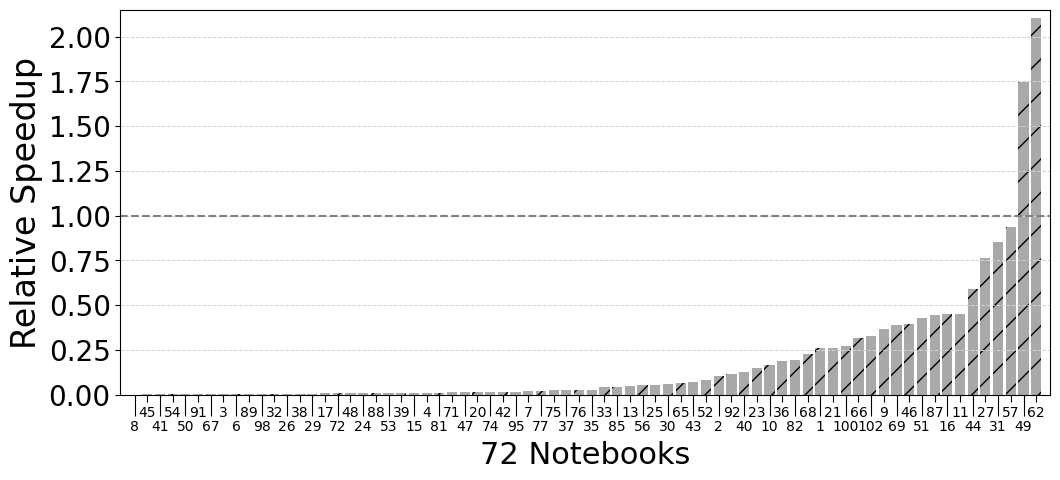

2
poiss0nriot_classifying-client-type-using-client-names.json
mahtieu_nyc-taxi-fare-prediction-data-expl-xgboost.json
narasimhach_ashrae-data-preprocessing.json
j0thu777_onlineretailanalysis.json
gravix_gradient-in-a-box.json
loveall_favorita-analytics.json
beratozmen_clash-of-clans-exploratory-data-analysis.json
chinstan_notebook249b4f3f5b.json
teemingyi_pubg-data-exploration-example-matches.json
maxiaoyue_data-cleaning-challenge-handling-missing-values.json


In [ ]:
gen_plots('modin', 'default', './output-stats/stats-pandas-default', './output-stats/stats-modin-default',
          '#A9A9A9', '/', fontsize=24, xticklabelsize=6, non_broken_ylim=(0, 2.15))

## Dask

0


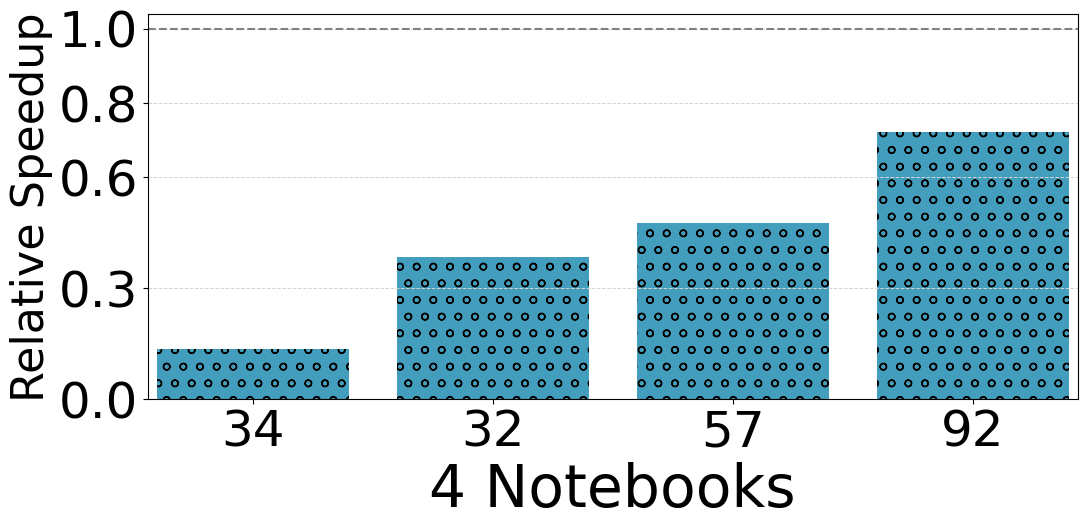

0
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
narasimhach_ashrae-data-preprocessing.json
jackwatson99_pima-indians-diabetes-rf-81.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json


In [ ]:
gen_plots('dask', '5_sec', './output-stats/stats-pandas-5-sec', './output-stats/stats-dask-5-sec',
          '#439DBC', 'o', fontsize=32, xticklabelsize=16, yticklabelsize=30, non_broken_ylim=(0, 1.04)) # ((0, 0.75), (1, 1.05)), [1, 15])

0


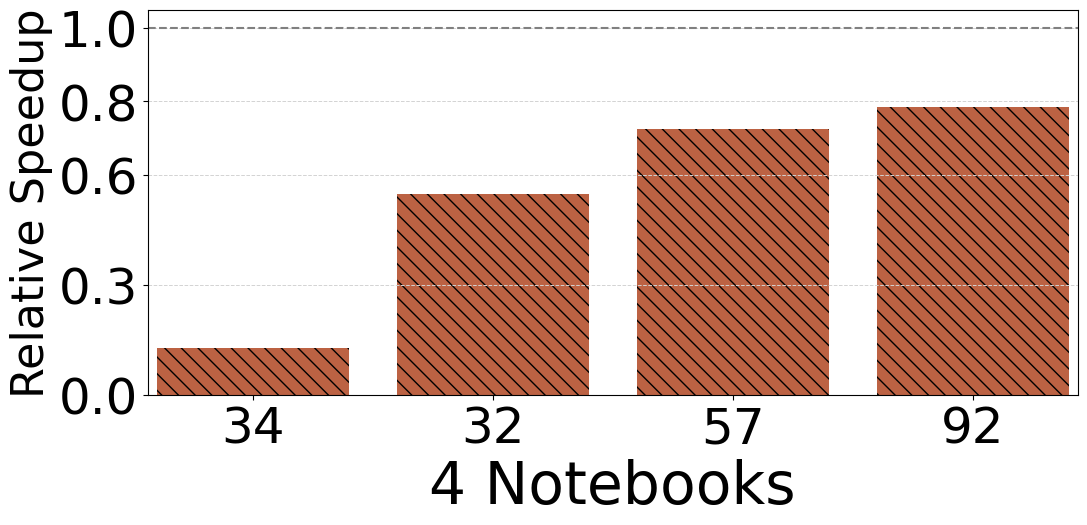

0
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
narasimhach_ashrae-data-preprocessing.json
jackwatson99_pima-indians-diabetes-rf-81.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json


In [ ]:
gen_plots('dask', '10_sec', './output-stats/stats-pandas-10-sec', './output-stats/stats-dask-10-sec',
          '#BC6243', '\\\\', fontsize=32, xticklabelsize=18, yticklabelsize=30, non_broken_ylim=(0, 1.05))

0


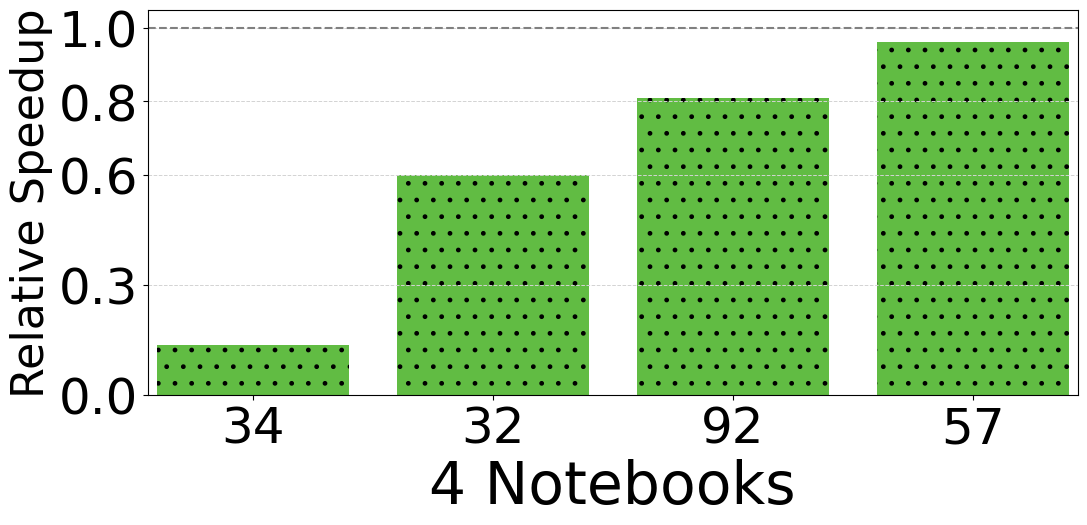

0
narasimhach_ashrae-data-preprocessing.json
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
jackwatson99_pima-indians-diabetes-rf-81.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json


In [ ]:
gen_plots('dask', '20_sec', './output-stats/stats-pandas-20-sec', './output-stats/stats-dask-20-sec',
          '#61BC43', '.', fontsize=32, xticklabelsize=18, yticklabelsize=30, non_broken_ylim=(0, 1.05))

0


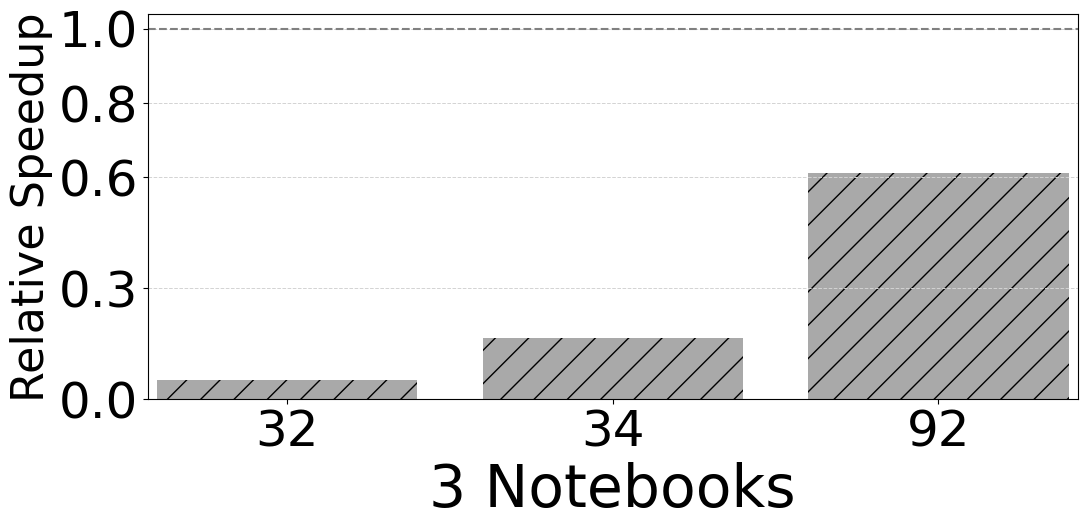

0
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json
jackwatson99_pima-indians-diabetes-rf-81.json


In [ ]:
gen_plots('dask', 'default', './output-stats/stats-pandas-default', './output-stats/stats-dask-default',
          '#A9A9A9', '/', fontsize=32, xticklabelsize=18, yticklabelsize=30, non_broken_ylim=(0, 1.04))

## Koalas

0


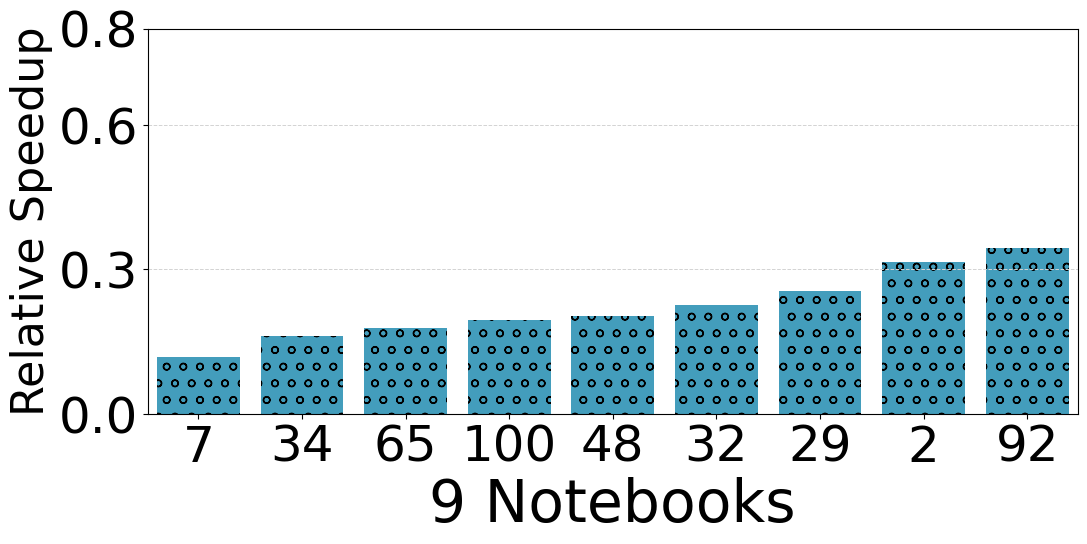

0
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
akshaypetkar_supermarket-sales-analysis.json
gsilves_quiz-4-question-1.json
jackwatson99_pima-indians-diabetes-rf-81.json
madseth_customer-shopping-trends-dataset-eda.json
yashjaiswal1097_911-emergency-calls-kernel.json
qnqfbqfqo_electric-vehicle-landscape-in-washington-state.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json
atultaur_house-sales-in-king-county.json


In [ ]:
gen_plots('koalas', '5_sec', './output-stats/stats-pandas-5-sec', './output-stats/stats-koalas-5-sec',
          '#439DBC', 'o', include_baseline=False, fontsize=32, xticklabelsize=18, yticklabelsize=30, non_broken_ylim=(0, 0.8)) # ((0, 0.34), (1, 1.05)), [1, 7])

0


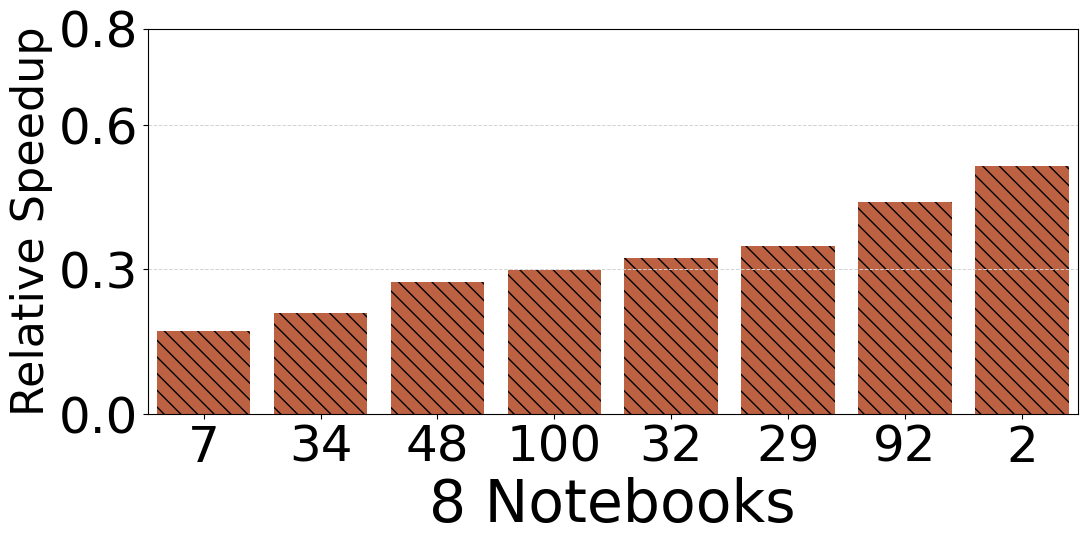

0
akshaypetkar_supermarket-sales-analysis.json
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
gsilves_quiz-4-question-1.json
jackwatson99_pima-indians-diabetes-rf-81.json
yashjaiswal1097_911-emergency-calls-kernel.json
madseth_customer-shopping-trends-dataset-eda.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json
atultaur_house-sales-in-king-county.json


In [ ]:
gen_plots('koalas', '10_sec', './output-stats/stats-pandas-10-sec', './output-stats/stats-koalas-10-sec',
          '#BC6243', '\\\\', include_baseline=False, fontsize=32, xticklabelsize=18, yticklabelsize=30, non_broken_ylim=(0, 0.8)) # ((0, 0.59), (1, 1.05)), [1, 12])

0


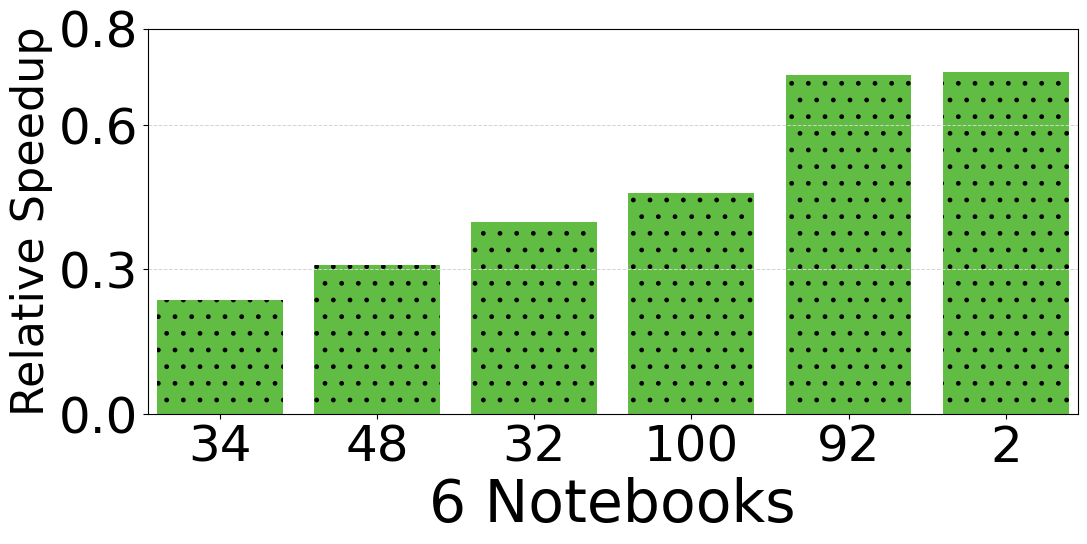

0
akshaypetkar_supermarket-sales-analysis.json
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
yashjaiswal1097_911-emergency-calls-kernel.json
jackwatson99_pima-indians-diabetes-rf-81.json
madseth_customer-shopping-trends-dataset-eda.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json


In [ ]:
gen_plots('koalas', '20_sec', './output-stats/stats-pandas-20-sec', './output-stats/stats-koalas-20-sec',
          '#61BC43', '.', fontsize=32, xticklabelsize=18, yticklabelsize=30, non_broken_ylim=(0, 0.8))

0


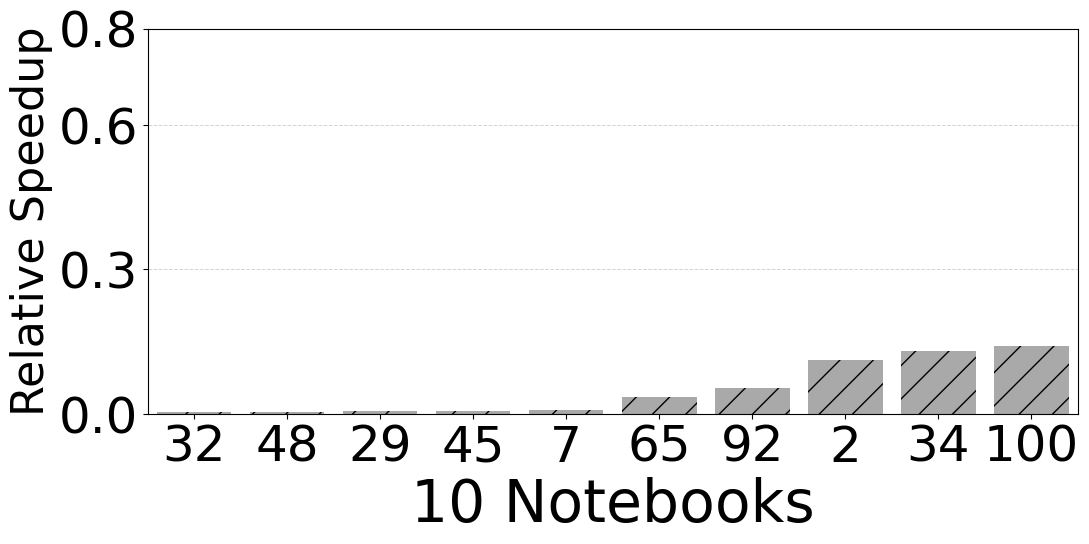

0
yashjaiswal1097_911-emergency-calls-kernel.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json
akshaypetkar_supermarket-sales-analysis.json
vatsalmavani_music-recommendation-system-using-spotify-dataset.json
qnqfbqfqo_electric-vehicle-landscape-in-washington-state.json
atultaur_house-sales-in-king-county.json
luckygemini_notebook5d5fc80c9f.json
gsilves_quiz-4-question-1.json
madseth_customer-shopping-trends-dataset-eda.json
jackwatson99_pima-indians-diabetes-rf-81.json


In [ ]:
gen_plots('koalas', 'default', './output-stats/stats-pandas-default', './output-stats/stats-koalas-default',
          '#A9A9A9', '/', include_baseline=False, fontsize=32, xticklabelsize=18, yticklabelsize=30, non_broken_ylim=(0, 0.8)) # ((0, 0.19), (1, 1.02)), [1, 10])

## Dias

18


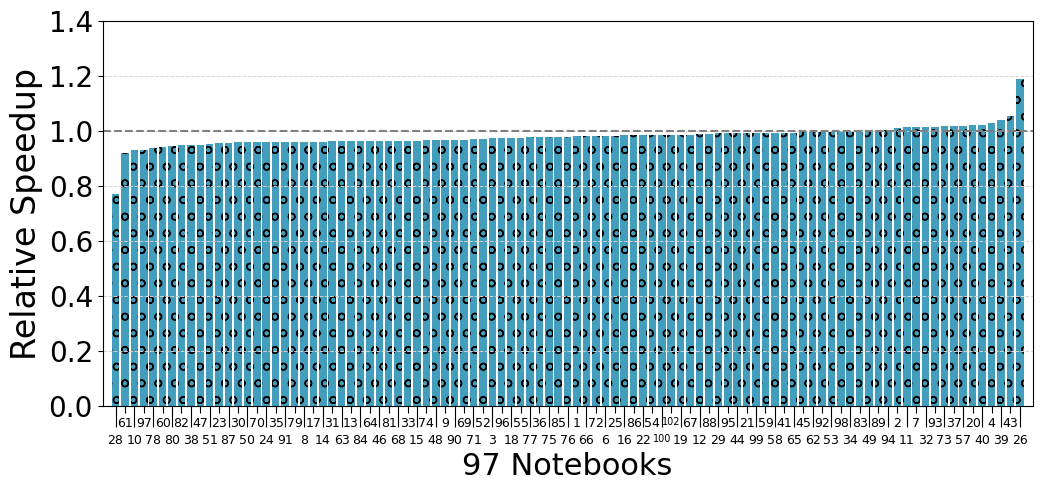

18
gmanish_help-ngo-country-clustering.json
kwullum_when-do-traffic-related-deaths-occur.json
kenjee_titanic-project-example.json
arjoonn_scout-script-7.json
kimtaehun_simple-preprocessing-for-time-series-prediction.json
dbatao_kernel2f80fc9d78.json
narasimhach_ashrae-data-preprocessing.json
jyotsananegi_melbourne-housing-snapshot-eda.json
saniaks_melbourne-house-price-eda.json
vbmokin_automatic-eda-with-pandas-profiling-2-9-09-2020.json


In [ ]:
gen_plots('dias', '5_sec', './output-stats/stats-pandas-5-sec', './output-stats/stats-dias-5-sec',
          '#439DBC', 'o', fig_text_x=0.02, fontsize=24, non_broken_ylim=(0, 1.4), xticklabelsize=4)

25


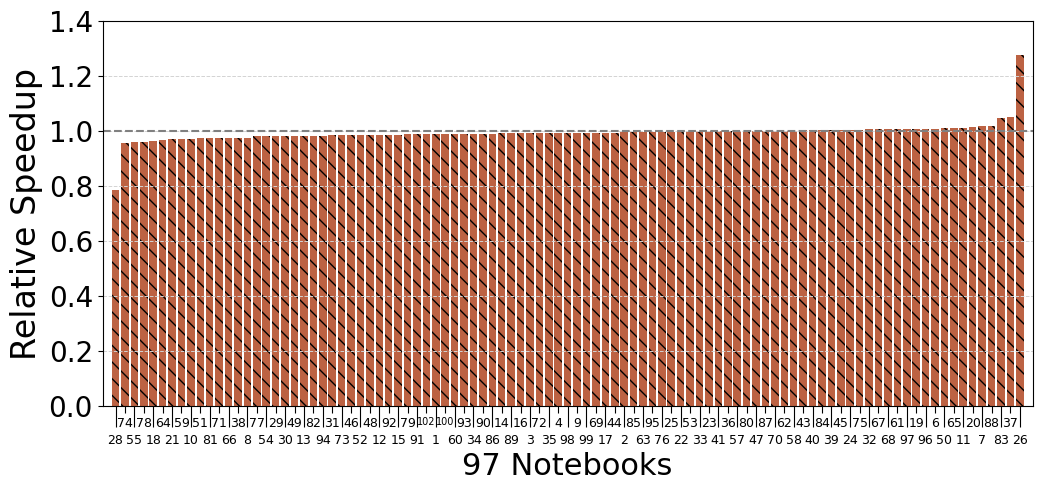

25
gmanish_help-ngo-country-clustering.json
jyotsananegi_melbourne-housing-snapshot-eda.json
sudheer259_house-price-prediction.json
thirumani_biggboss-hindi-telugu-tamil-kannada-marathi-bangla.json
atultaur_house-sales-in-king-county.json
dbatao_kernel2f80fc9d78.json
beratozmen_clash-of-clans-exploratory-data-analysis.json
qnqfbqfqo_electric-vehicle-landscape-in-washington-state.json
mathewvondersaar_analysis-of-student-performance.json
ashukr_first-step-ingestion-to-prediction.json


In [ ]:
gen_plots('dias', '10_sec', './output-stats/stats-pandas-10-sec', './output-stats/stats-dias-10-sec',
          '#BC6243', '\\\\', fig_text_x=0.02, fontsize=24, non_broken_ylim=(0, 1.4), xticklabelsize=4)

55


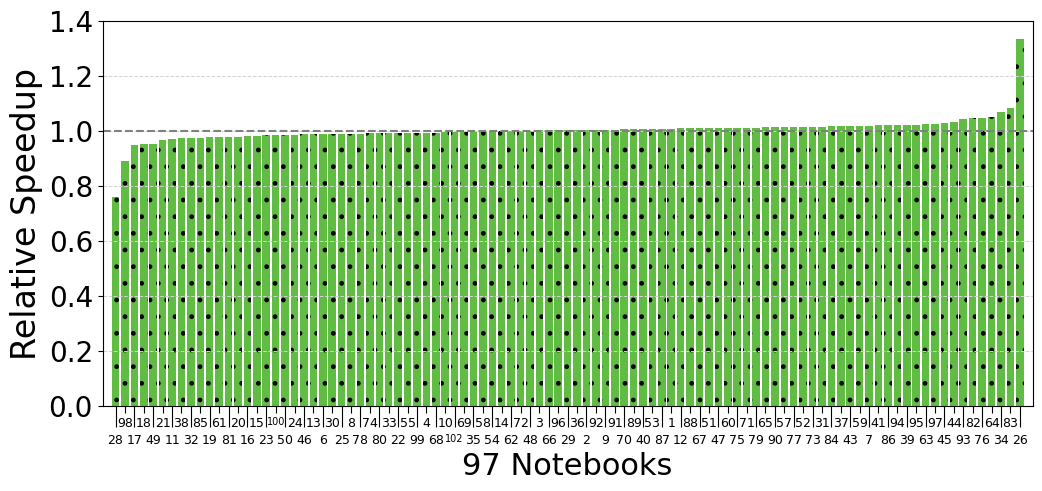

55
gmanish_help-ngo-country-clustering.json
sudheer259_house-price-prediction.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json
qingyuanwu_deep-neural-network.json
seriousran_eda-ing.json
stefanjov_my-first-normalize-on-big-dataset.json
vbmokin_automatic-eda-with-pandas-profiling-2-9-09-2020.json
loveall_favorita-analytics.json
luckygemini_notebook5d5fc80c9f.json
wyl4417_machine-learning-and-how-it-affects-you.json


In [ ]:
gen_plots('dias', '20_sec', './output-stats/stats-pandas-20-sec', './output-stats/stats-dias-20-sec',
          '#61BC43', '.', fig_text_x=0.02, fontsize=24, non_broken_ylim=(0, 1.4), xticklabelsize=4)

19


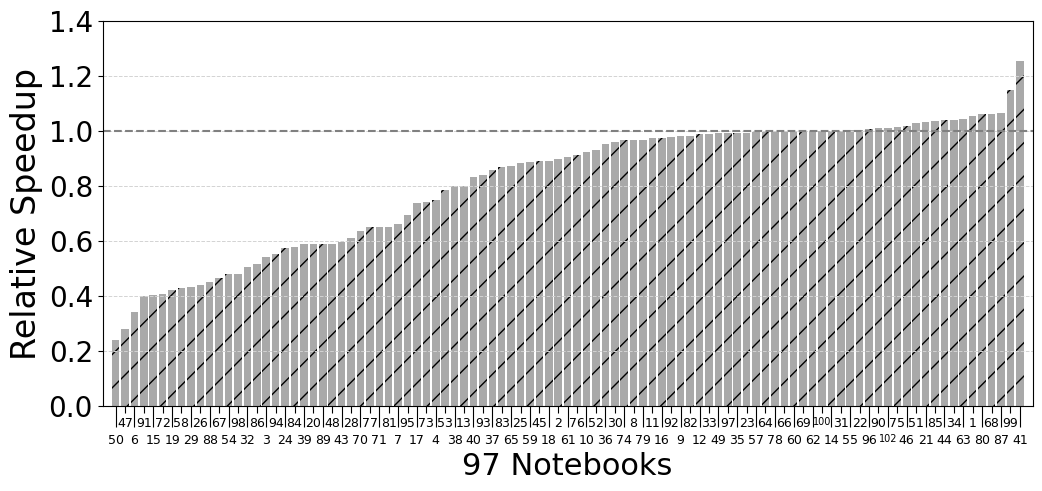

19
kmader_analyzing-matches.json
xokent_cyber-security-attack-eda.json
teemingyi_pubg-data-exploration-example-matches.json
roopahegde_cryptocurrency-price-correlation.json
shunjiangxu_blood-is-thicker-than-water-friendship-forever.json
akgauravin_gun-violence-data-exploration-and-plotting.json
pradeepjeya_allstate-encoding-high-cardinality-features.json
jaideepvalani_useful-eda-for-beginners-rsna-embolism.json
loveall_favorita-analytics.json
tanulsingh077_twitter-sentiment-extaction-analysis-eda-and-model.json


In [ ]:
gen_plots('dias', 'default', './output-stats/stats-pandas-default', './output-stats/stats-dias-default',
          '#A9A9A9', '/', fontsize=24, xticklabelsize=4, non_broken_ylim=(0, 1.4))